In [1]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset, DatasetDict
from data_loader import *

import pandas as pd
import numpy as np
import warnings
import torch
import os

warnings.filterwarnings("ignore")

In [15]:
MODEL = "howey/electra-base-mnli"
LOAD_SAVED_MODEL = False
model_dir = 'models/electra-base-mnli/'
data_dir = 'data/argumentation/'

In [26]:
train_df, dev_df, test_df = load_augmented_data('cckg')


train_df.drop(columns=['topic'], inplace=True)
dev_df.drop(columns=['topic'], inplace=True)
test_df.drop(columns=['topic'], inplace=True)
# some different topics have the same arguments -- when we drop topics, we should then drop duplicate arguments
train_df = train_df.drop_duplicates()
dev_df = dev_df.drop_duplicates()
test_df = test_df.drop_duplicates()

logic_train, logic_dev, logic_test  = load_logic_data()
logic_train['label'] = 0
logic_dev['label'] = 0
logic_test['label'] = 0

train_df = pd.concat([train_df, logic_train]).sample(frac=1, random_state=42)
dev_df = pd.concat([dev_df, logic_dev]).sample(frac=1, random_state=42)
test_df = pd.concat([test_df, logic_test]).sample(frac=1, random_state=42)

label_encoder = LabelEncoder()
label_encoder.fit(train_df['fallacy type'])
train_df['fallacy type'] = label_encoder.transform(train_df['fallacy type'])
dev_df['fallacy type'] = label_encoder.transform(dev_df['fallacy type'])
test_df['fallacy type'] = label_encoder.transform(test_df['fallacy type'])

In [28]:
model = AutoModelForSequenceClassification.from_pretrained(model_dir if LOAD_SAVED_MODEL else MODEL, num_labels=len(label_encoder.classes_), ignore_mismatched_sizes=True)
tokenizer = AutoTokenizer.from_pretrained(model_dir if LOAD_SAVED_MODEL else MODEL)

if torch.cuda.is_available():
    model = model.cuda()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at howey/electra-base-mnli and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([14, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
training_args = TrainingArguments(
    output_dir=f'./results/{MODEL.split("/")[-1]}',
    do_eval=True,
    do_train=True,
    num_train_epochs=3,
    save_total_limit=3,
    load_best_model_at_end=True,
    learning_rate=8.5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="steps",
    logging_strategy="steps",
    evaluation_strategy="steps",
    logging_steps=300,
    eval_steps=300,
    save_steps=300,
)
def compute_metrics(pred):
            labels = pred.label_ids
            preds = pred.predictions.argmax(-1)
            precision, recall, f1, _ = precision_recall_fscore_support(
                labels, preds, average="weighted"
            )
            acc = accuracy_score(labels, preds)
            return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [30]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df),
    'validation': Dataset.from_pandas(dev_df),
    'test': Dataset.from_pandas(test_df)
})

def process(batch):
    inputs = tokenizer(batch["argument"], truncation=True, padding="max_length")
    return {
            "input_ids": inputs["input_ids"],
            "attention_mask": inputs["attention_mask"],
            "labels": batch["fallacy type"],
        }
    
tokenized_dataset = dataset.map(
    process,
    batched=True, 
    remove_columns=['label'])

trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["validation"],
        tokenizer=tokenizer,
    )
if not LOAD_SAVED_MODEL:
    trainer.train()
    trainer.save_model(f'models/{MODEL.split("/")[-1]}-M3')
    preds = trainer.predict(tokenized_dataset['test'])
    print(preds.metrics)

Map:   0%|          | 0/12108 [00:00<?, ? examples/s]

Map:   0%|          | 0/2160 [00:00<?, ? examples/s]

Map:   0%|          | 0/2190 [00:00<?, ? examples/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Failed to detect the name of

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
300,1.204900,0.775796,0.768519,0.757580,0.782823,0.768519
600,0.629900,0.672924,0.806944,0.802795,0.808355,0.806944
900,0.505700,0.691426,0.813426,0.811026,0.830525,0.813426
1200,0.395800,0.649131,0.824537,0.824839,0.827790,0.824537
1500,0.379500,0.627355,0.825000,0.826386,0.840511,0.825000
1800,0.218900,0.663504,0.838426,0.840302,0.848322,0.838426
2100,0.200200,0.659926,0.837037,0.840437,0.849761,0.837037


{'test_loss': 0.6274633407592773, 'test_accuracy': 0.8228310502283105, 'test_f1': 0.8281170172305695, 'test_precision': 0.8407563511634983, 'test_recall': 0.8228310502283105, 'test_runtime': 41.5358, 'test_samples_per_second': 52.726, 'test_steps_per_second': 3.298}


In [31]:
from eval import Eval
eval = Eval(model, tokenizer, label_encoder)

# Test set evaluation

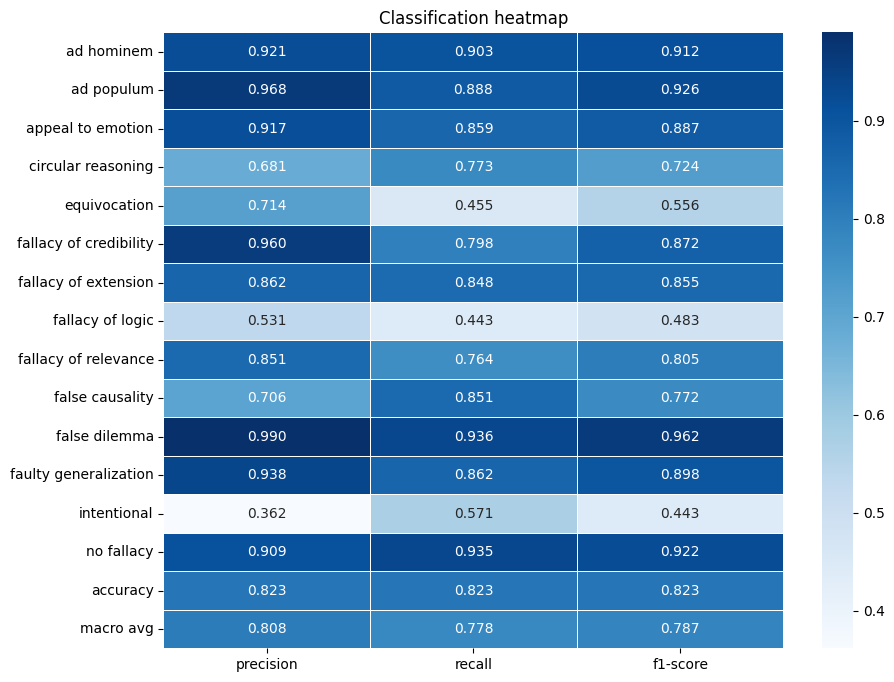

In [32]:
y_test, y_pred = eval.eval_data(test_df)
eval.plot_heatmap(y_test, y_pred)


# Argotario evaluation

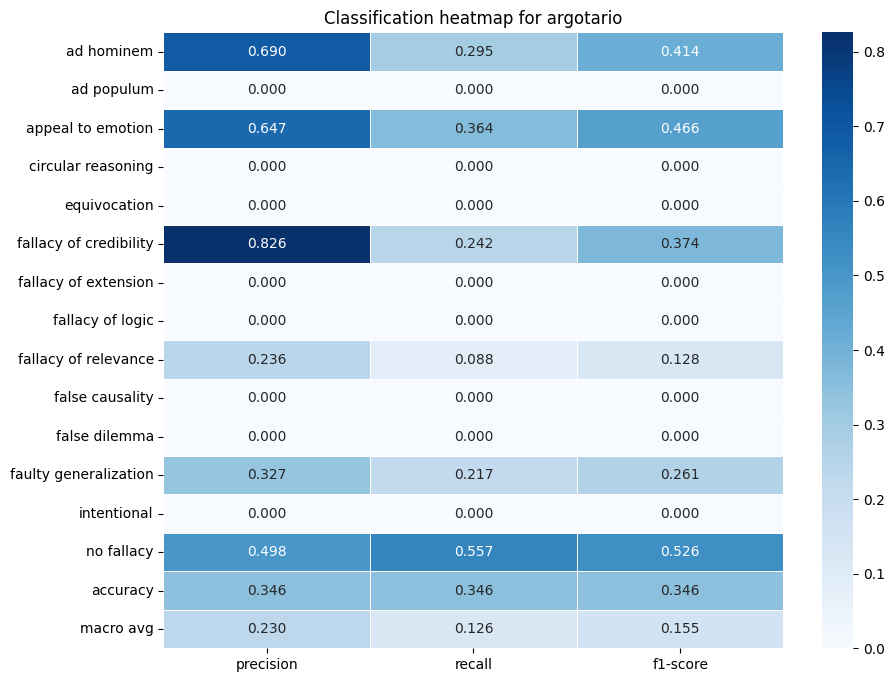

In [33]:
y_test_argotario, y_pred_argotario = eval.eval_data(load_argotario_data(label_encoder))
eval.plot_heatmap(y_test=y_test_argotario, y_pred=y_pred_argotario, title="Classification heatmap for argotario")

# Logic dataset evaluation

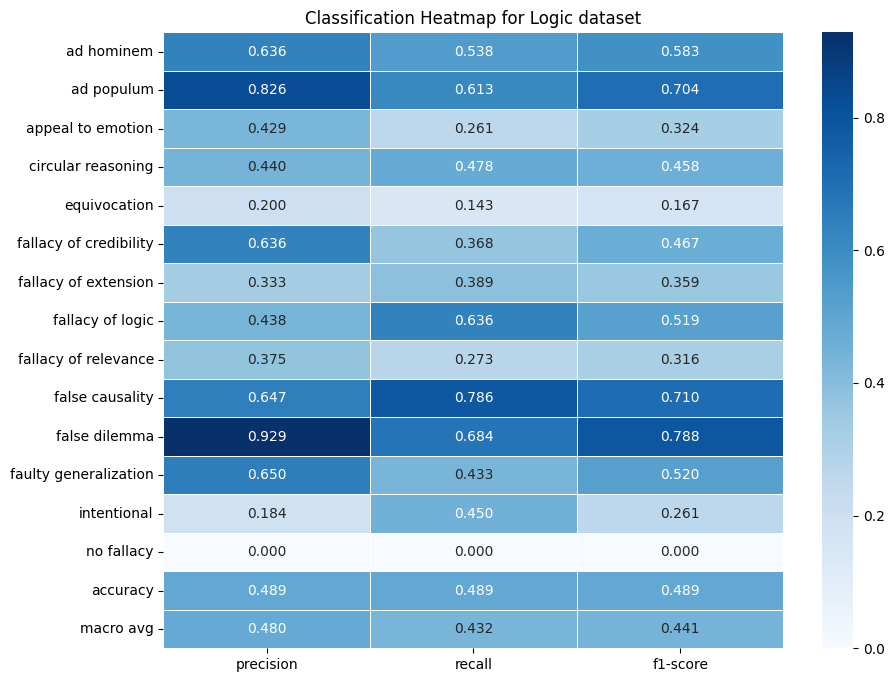

In [34]:
_,_, test_logic = load_logic_data()
test_logic['fallacy type'] = label_encoder.transform(test_logic['fallacy type'])
y_test_logic, y_pred_logic = eval.eval_data(test_logic)
eval.plot_heatmap(y_test_logic, y_pred_logic, title="Classification Heatmap for Logic dataset")